In [92]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.api import stats
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns

Import raw data from local drive. 

In [93]:
file_name = "Experimental_Structure_Data_05032025.xlsx"

fish = pd.read_excel(file_name, sheet_name='Fish')
relief = pd.read_excel(file_name, sheet_name='Relief')
species_codes = pd.read_excel(file_name, sheet_name='Species_Codes')

## Prepare Data

Calculate mean relief of each transect. Calculate standardized metrics for relief and substrate for each transect, and categorize transects as "High" or "Low" relief based on whether the mean relief values fall above or below 1.5, respectively. 

In [94]:
mean_relief= relief.groupby('Transect_Number')['Relief'].mean().reset_index(name='Mean_Relief')

mean_relief['Relief_Category'] = mean_relief['Mean_Relief'].apply(
    lambda x: 'High' if x >= 1.5 else 'Low'
)

Clean and prepare fish data. Calculate weighted size using size class data and pivot fish variables into workable format. 

In [95]:
fish_master = fish.merge(species_codes, on='Species', how='right')
fish_master = fish_master.merge(mean_relief, on = 'Transect_Number', how = 'right')

metadata = ['Date', 'Location', 'Recorder', 
                    'Buddy', 'Heading', 'Depth_ft', 'Unnamed: 13']

fish_master = fish_master.drop(columns=metadata)
fish_master

,Transect_Number,Treatment,Treatment_Time,Position,Species,Size_cm,Count,Species.1,Common_Name,Mobility,Mean_Relief,Relief_Category
0,2,Post-Kelp,1_hour,Benthic,SSER,25.0,1,RVAC,Olive rockfish,Intermediate,2.2,High
1,2,Pre-Kelp,0_hours,Mid-Column,SMYS,15.0,6,SATR,Blue rockfish,Midcolumn,2.2,High
2,2,Pre-Kelp,0_hours,Mid-Column,SMYS,20.0,6,EJAC,Blue rockfish,Midcolumn,2.2,High
3,2,Post-Kelp,1_hour,Mid-Column,SMYS,5.0,1,SMEL,Blue rockfish,Midcolumn,2.2,High
4,2,Post-Kelp,1_hour,Mid-Column,SMYS,15.0,4,NaN,Blue rockfish,Midcolumn,2.2,High
...,...,...,...,...,...,...,...,...,...,...,...,...
166,11,Post-Kelp,1_hour,NaN,HDEC,30.0,1,NaN,Kelp greenling,Benthic,1.5,High
167,11,Pre-Kelp,0_hours,NaN,OPIC,15.0,1,NaN,Painted greenling,Benthic,1.5,High
168,11,Post-Kelp,1_hour,NaN,OPIC,5.0,1,NaN,Painted greenling,Benthic,1.5,High
169,11,Pre-Kelp,0_hours,NaN,ELAT,15.0,11,NaN,Striped surfperch,Intermediate,1.5,High


Calculate total abundance, density, richness, biodiversity, and weighted size by transect and mobility cateogry. 

In [96]:
# Compute Weighted Size
fish_master['Weighted_Size_cm'] = fish_master['Size_cm'] * fish_master['Count']

# Group and aggregate by Transect, Treatment Time, Relief Category, and Mobility
aggregated = fish_master.groupby(['Transect_Number', 'Treatment_Time', 'Relief_Category', 'Mobility']).agg(
    total_abundance=('Count', 'sum'),
    total_density=('Count', lambda x: x.sum() / 20),  # adjust denominator as needed
    total_weighted_size=('Weighted_Size_cm', 'sum'),
    total_richness=('Species', 'nunique')
).reset_index()

# Define Shannon Index function
def shannon_diversity(group):
    species_counts = group['Count']
    proportions = species_counts / species_counts.sum()
    return -(proportions * np.log(proportions)).sum()

# Calculate Shannon Index grouped the same way
shannon = fish_master.groupby(['Transect_Number', 'Treatment_Time', 'Relief_Category', 'Mobility']).apply(
    shannon_diversity
).reset_index(name='total_biodiversity')

# Merge biodiversity index into main stats
fish_stats = aggregated.merge(shannon, on=['Transect_Number', 'Treatment_Time', 'Relief_Category', 'Mobility'], how='left')


C:\Users\FELAB\AppData\Local\Temp\ipykernel_18944\3535749249.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shannon = fish_master.groupby(['Transect_Number', 'Treatment_Time', 'Relief_Category', 'Mobility']).apply(


In [97]:
def compute_statistics(df, column_name, metric_prefix):
    stats = df.groupby(['Relief_Category', 'Mobility'])[column_name].agg(
        mean_value='mean',
        std_value='std',
        count_value='size'
    ).reset_index()

    stats.rename(columns={
        'mean_value': f'mean_{metric_prefix}',
        'std_value': f'std_{metric_prefix}',
        'count_value': f'count_{metric_prefix}'
    }, inplace=True)

    stats[f'std_error_{metric_prefix}'] = stats[f'std_{metric_prefix}'] / np.sqrt(stats[f'count_{metric_prefix}'])

    return stats


In [98]:
density_stats       = compute_statistics(fish_stats, 'total_density', 'density')
biodiversity_stats  = compute_statistics(fish_stats, 'total_biodiversity', 'biodiversity')
size_stats          = compute_statistics(fish_stats, 'total_weighted_size', 'size')
richness_stats      = compute_statistics(fish_stats, 'total_richness', 'richness')

richness_stats

,Relief_Category,Mobility,mean_richness,std_richness,count_richness,std_error_richness
0,High,Benthic,2.888889,0.927961,9,0.309320
1,High,Intermediate,1.384615,0.650444,13,0.180401
2,High,Midcolumn,1.187500,0.403113,16,0.100778
3,Low,Benthic,2.272727,0.786245,11,0.237062
4,Low,Intermediate,1.500000,0.534522,8,0.188982
5,Low,Midcolumn,1.000000,0.000000,10,0.000000


In [99]:
metrics_to_melt = ['total_density', 'total_richness', 
                   'total_biodiversity', 'total_weighted_size'] 

melted_df = pd.melt(fish_stats, id_vars=['Transect_Number', 'Relief_Category', 'Mobility'], 
                    value_vars=metrics_to_melt, 
                    var_name='Metric', value_name='Value')
melted_df

,Transect_Number,Relief_Category,Mobility,Metric,Value
0,2,High,Intermediate,total_density,0.05
1,2,High,Midcolumn,total_density,1.10
2,2,High,Intermediate,total_density,0.10
3,2,High,Midcolumn,total_density,0.80
4,2,High,Intermediate,total_density,0.05
...,...,...,...,...,...
263,11,High,Intermediate,total_weighted_size,180.00
264,11,High,Midcolumn,total_weighted_size,145.00
265,11,High,Benthic,total_weighted_size,100.00
266,11,High,Intermediate,total_weighted_size,15.00


In [100]:
def run_two_way_anova(stats, metric_column):
    model = ols(f'Value ~ C(Relief_Category) * C(Mobility)', data=stats[stats['Metric'] == metric_column]).fit()
    anova_table = anova_lm(model, typ=2)  # Type II Sum of Squares
    print(f"\nANOVA Results for {metric_column}:")
    print(anova_table)
    return anova_table

def run_tukey_hsd(stats, metric_column):
    data = stats[stats['Metric'] == metric_column].copy()
    data['Group'] = data['Relief_Category'].astype(str) + '_' + data['Mobility'].astype(str)
    
    tukey = pairwise_tukeyhsd(data['Value'], data['Group'], alpha=0.05)
    print(f"\nTukey's HSD Results for {metric_column}:")
    print(tukey.summary())
    return tukey


# Run Two-Way ANOVA and Tukey's HSD for each metric
for metric in metrics_to_melt:
    print(f"\n### Analyzing {metric} ###")
    run_two_way_anova(melted_df, metric)
    run_tukey_hsd(melted_df, metric)



### Analyzing total_density ###

ANOVA Results for total_density:
                                   sum_sq    df          F        PR(>F)
C(Relief_Category)               1.297943   1.0   6.616679  1.255332e-02
C(Mobility)                     12.239374   2.0  31.197069  4.656684e-10
C(Relief_Category):C(Mobility)   2.793794   2.0   7.121131  1.661398e-03
Residual                        11.965897  61.0        NaN           NaN

Tukey's HSD Results for total_density:
           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
     High_Benthic High_Intermediate  -0.1026 0.9945 -0.6676  0.4625  False
     High_Benthic    High_Midcolumn   1.1667    0.0  0.6237  1.7096   True
     High_Benthic       Low_Benthic    0.103 0.9953 -0.4827  0.6887  False
     High_Benthic  Low_Intermediate  -0.1208 0.9931  -0.754  0.5124  False
   

In [101]:
def plot_statistics_by_relief_and_mobility(stats, y_column, y_label, metric_name):
    plt.figure(figsize=(10, 6))

    # Relief label mapping and order
    relief_label_map = {
        'Low': 'Low Relief',
        'High': 'High Relief'
    }
    relief_levels = ['Low', 'High']
    relief_labels = [relief_label_map[r] for r in relief_levels]

    # Custom mobility order
    mobility_categories = ['Benthic', 'Intermediate', 'Midcolumn']

    # Use seaborn's colorblind palette
    colors = sns.color_palette("colorblind", len(mobility_categories))

    stats = stats.copy()
    stats['Relief_Label'] = stats['Relief_Category'].map(relief_label_map)

    width = 0.25
    legend_labels = []

    for j, mobility in enumerate(mobility_categories):
        for i, relief_cat in enumerate(relief_levels):
            subset = stats[(stats['Relief_Category'] == relief_cat) & 
                           (stats['Mobility'] == mobility)]

            if subset.empty:
                continue

            row = subset.iloc[0]
            bar_x = i + j * width
            mean_value = row[y_column]
            std_error = row[f'std_error_{metric_name}']

            plt.bar(bar_x, mean_value, width=width, color=colors[j])
            plt.errorbar(bar_x, mean_value, yerr=std_error, fmt='none',
                         color='black', capsize=5, elinewidth=1)

        legend_labels.append(mobility)

    # Set x-ticks
    base_x = np.arange(len(relief_levels))
    center_offset = (width * (len(mobility_categories) - 1)) / 2
    plt.xticks(base_x + center_offset, relief_labels)

    plt.xlabel('Relief Category')
    plt.ylabel(y_label)

    # Reorder legend
    legend_handles = [Line2D([0], [0], color=colors[j], lw=6) for j in range(len(mobility_categories))]
    plt.legend(legend_handles, legend_labels, title='Mobility')

    plt.tight_layout()
    filename = f'{metric_name}_reliefxmobility_plot.jpg'
    plt.savefig(filename, dpi=300, bbox_inches='tight', format='jpg')
    plt.show()
    print(f"Figure saved as {filename}")


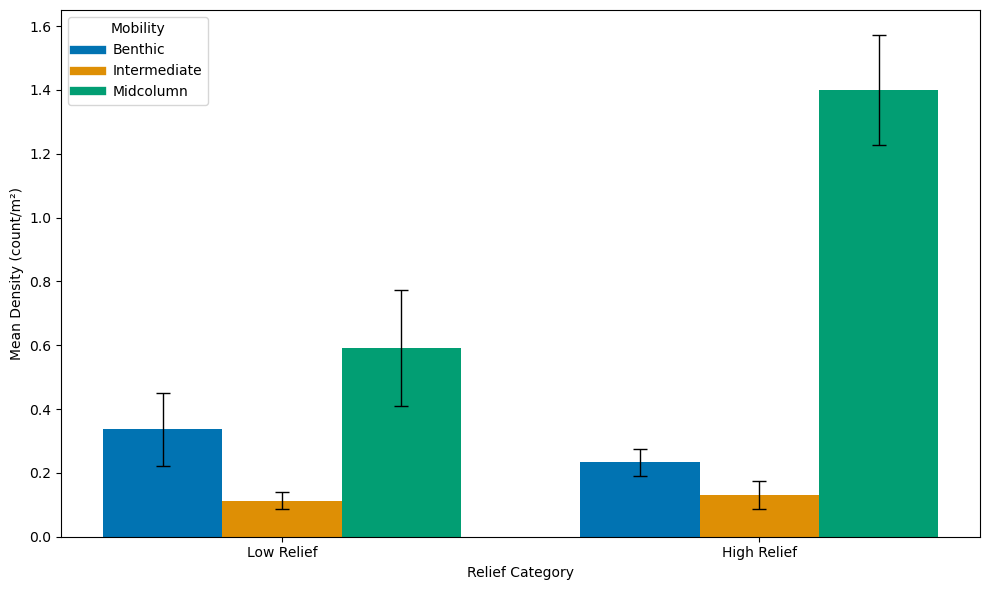

Figure saved as density_reliefxmobility_plot.jpg


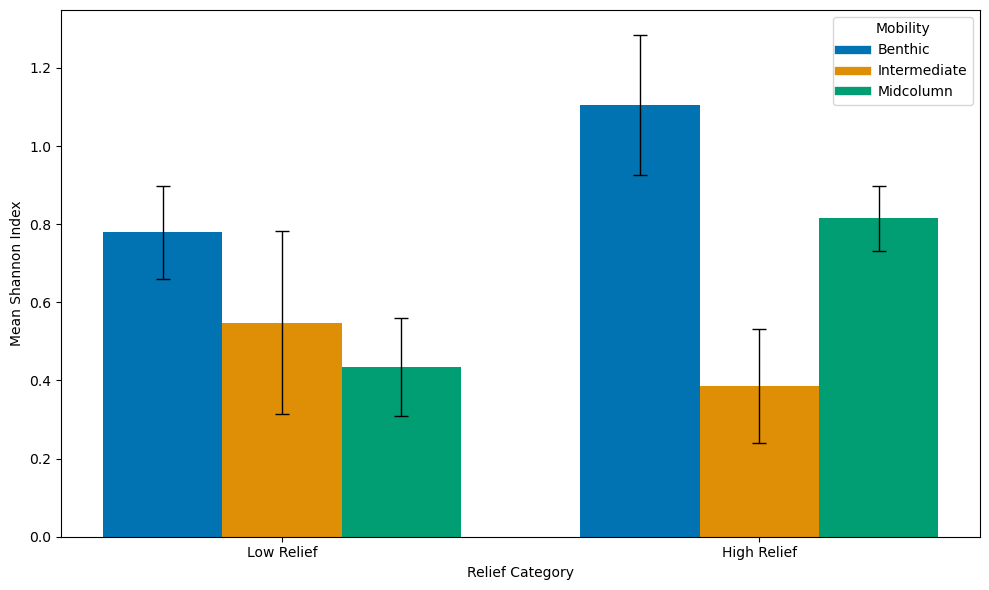

Figure saved as biodiversity_reliefxmobility_plot.jpg


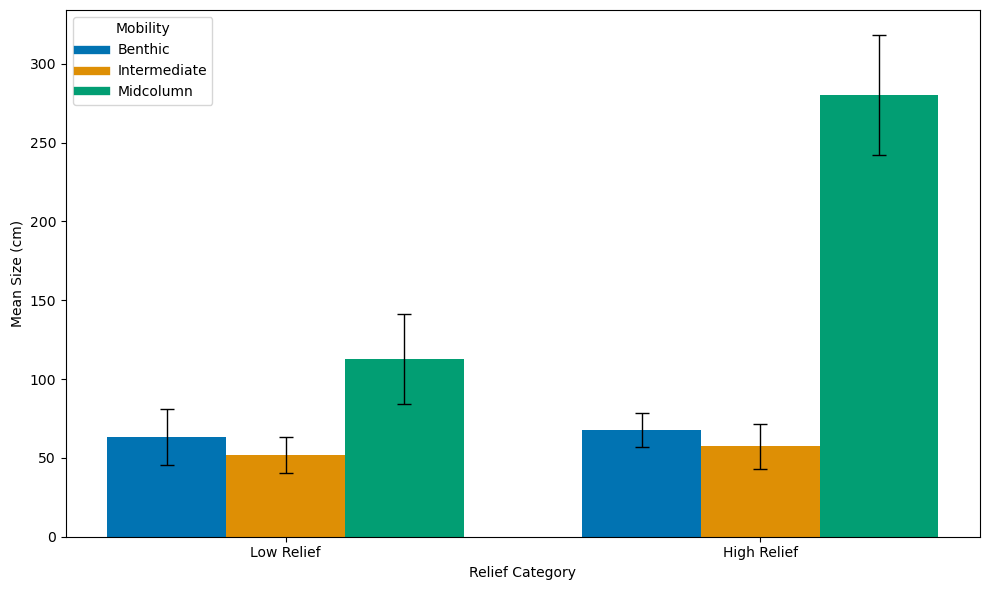

Figure saved as size_reliefxmobility_plot.jpg


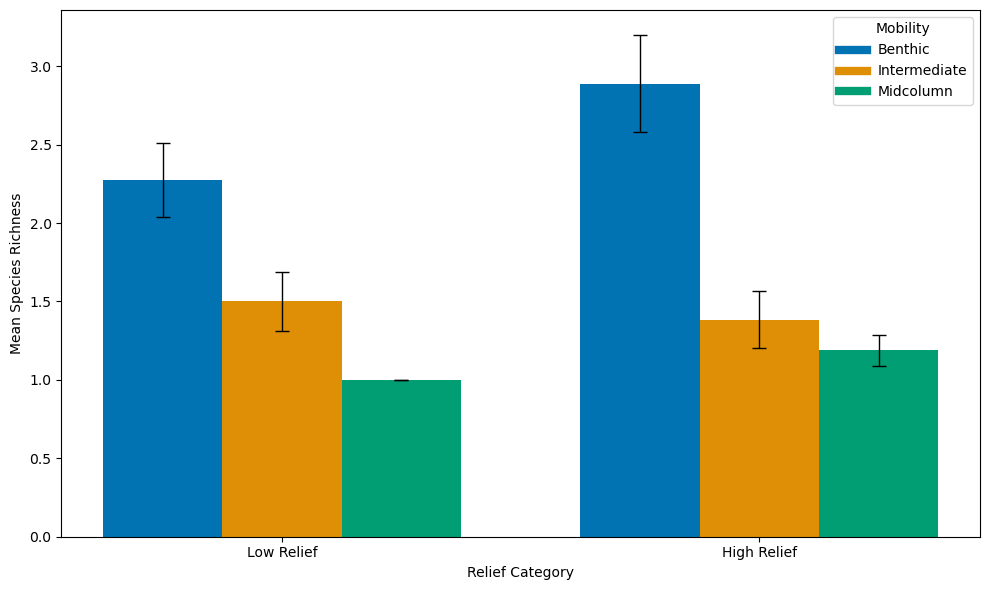

Figure saved as richness_reliefxmobility_plot.jpg


In [102]:
plot_statistics_by_relief_and_mobility(density_stats, 'mean_density', 'Mean Density (count/m²)', 'density')
plot_statistics_by_relief_and_mobility(biodiversity_stats, 'mean_biodiversity', 'Mean Shannon Index', 'biodiversity')
plot_statistics_by_relief_and_mobility(size_stats, 'mean_size', 'Mean Size (cm)', 'size')
plot_statistics_by_relief_and_mobility(richness_stats, 'mean_richness', 'Mean Species Richness', 'richness')
